In [2]:
from data_processing.clinvar import getClinvar
from data_processing.main import get_gene_info
from main import load_data
from pathlib import Path
import os
from tqdm.autonotebook import tqdm
import json
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [3]:
cache_dir = Path("/data/dzeiberg/mave_calibration/cache")
cache_dir.mkdir(exist_ok=True, parents=True)
data_directory = Path("/data/dzeiberg/mave_calibration/data")
dataset_names = [os.path.basename(f.parent) for f in data_directory.glob("**/observations.pkl")]
metadata = []
for dataset in dataset_names:
    with open(data_directory / dataset / "metadata.json") as f:
        metadata.append(dict(**json.load(f), dataset=dataset))
metadata = pd.DataFrame(metadata).set_index("dataset")
gene_info = {}
for uniprot_acc in tqdm(metadata["uniprot_acc"].unique()):
    gene_info[uniprot_acc] = get_gene_info(uniprot_acc, cache_dir="/data/dzeiberg/mave_calibration/cache")
gene_info = pd.DataFrame(gene_info).T

  0%|          | 0/11 [00:00<?, ?it/s]

In [3]:
clinvar = getClinvar(cache_dir=cache_dir, use_cached_processed_file=True)

In [9]:
vus_records = clinvar[(clinvar.transcript.isin(set(gene_info.MANE_RefSeq_nuc.values))) & \
        (clinvar.ClinicalSignificance == "Uncertain significance") & \
            (clinvar.snv_category == "missense")]

In [10]:
vus_records.drop_duplicates(subset=["Name"]).GeneSymbol.value_counts()

GeneSymbol
BRCA2        3176
MSH2         1659
CHEK2        1623
BRCA1        1498
PTEN          715
TP53          639
NPC1          454
VHL           419
HMBS          154
DDX3X         126
TPMT           10
KLLN;PTEN       1
Name: count, dtype: int64

In [11]:
WRITE_VCF = False
if WRITE_VCF:
    vus_records[vus_records.Assembly == "GRCh38"].sort_values("#AlleleID").head()
    vcf_header = """##fileformat=VCFv4.2
    #CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO
    """

    def to_vcf(r):
        return f"{r.Chromosome}\t{r.Start}\t{r['#AlleleID']}\t{r.ReferenceAlleleVCF}\t{r.AlternateAlleleVCF}\t.\t.\t.\n"
    with open(cache_dir / "clinvar_2024-08_missense_vus.vcf", "w") as f:
        f.write(vcf_header)
        for i, r in vus_records.iterrows():
            f.write(to_vcf(r))

In [12]:
dbnsfp_out = pd.read_csv("/data/dzeiberg/mave_calibration/cache/clinvar_2024-08_missense_vus.vcf.out", sep="\t")
dbnsfp_out = dbnsfp_out.assign(**{"#chr": dbnsfp_out["#chr"].astype(str)})

/tmp/ipykernel_1592403/1410165219.py:1: DtypeWarning: Columns (0,7,9,38,41,62,65,68,69,70,72,73,75,77,79,80,83,90,107,108,111,122,138,161,162,163,164,165,166,169,170,171,172,173,174,175,176,177,178,179,180,188,189,194,195,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  dbnsfp_out = pd.read_csv("/data/dzeiberg/mave_calibration/cache/clinvar_2024-08_missense_vus.vcf.out", sep="\t")


In [13]:
def get_score_df(r):
    rdf = pd.DataFrame.from_records(r[["Ensembl_transcriptid","HGVSc_ANNOVAR","Uniprot_acc","REVEL_score", "AlphaMissense_score"]].str.split(";")).T
    rdf.columns = ["Ensembl_transcriptid","HGVSc_ANNOVAR","Uniprot_acc","REVEL_score", "AlphaMissense_score"]
    return rdf
    return rdf.loc[rdf.Ensembl_transcriptid.isin(set(gene_info.ENSEMBL_nuc.str.split(".").str[0].values)), ["REVEL_score", "AlphaMissense_score"]]



In [14]:
def avg_scores(s):
    return np.nanmean([float(x) for x in s.split(";") if x != "."])

In [15]:
dbnsfp_out = dbnsfp_out.assign(REVEL_score_avg=dbnsfp_out.REVEL_score.apply(avg_scores),
    gnomAD_exomes_AF= dbnsfp_out.gnomAD_exomes_AF.apply(pd.to_numeric, errors="coerce"),
    gnomAD_genomes_AF= dbnsfp_out.gnomAD_genomes_AF.apply(pd.to_numeric, errors="coerce"))

/tmp/ipykernel_1592403/2128533029.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean([float(x) for x in s.split(";") if x != "."])


In [16]:
rmc = pd.read_csv("/data/dbs/gnomad/release/2.1.1/regional_missense_constraint/gnomAD_v2.1.1_transcripts_with_rmc.tsv",delimiter='\t')
rmc = rmc.assign(hg19_chr=rmc.start_coordinate.str.split(":").str[0],
                    hg19_start=rmc.start_coordinate.str.split(":").str[1].astype(int),
                    hg19_end=rmc.stop_coordinate.str.split(":").str[1].astype(int))

In [17]:
dbnsfp_out.loc[:,"hg19_pos(1-based)"] = dbnsfp_out.loc[:,"hg19_pos(1-based)"].astype(int)
dbnsfp_out.loc[:,"hg19_chr"] = dbnsfp_out.loc[:,"hg19_chr"].astype(str)

In [18]:
def get_rmc_oe(dbnsfp_r):
    rows = rmc.loc[(rmc.hg19_chr == dbnsfp_r.hg19_chr) & \
                (rmc.hg19_start <= dbnsfp_r["hg19_pos(1-based)"]) & \
                    (rmc.hg19_end >= dbnsfp_r["hg19_pos(1-based)"]), "oe"]
    if len(rows) == 0:
        return np.nan
    return rows.iloc[0]

In [19]:
dbnsfp_oe_vals = dbnsfp_out.progress_apply(get_rmc_oe, axis=1)
dbnsfp_out = dbnsfp_out.assign(rmc_oe=dbnsfp_oe_vals)

100%|██████████| 10600/10600 [00:15<00:00, 680.24it/s]


In [25]:
dbnsfp_out.rmc_oe.isna().sum()

np.int64(9302)

In [20]:
dbnsfp = dbnsfp_out.set_index(["#chr","pos(1-based)","ref","alt"])

In [21]:
vus_records = vus_records.assign(POS=vus_records.POS.astype(int))

In [22]:
df = pd.merge(vus_records.drop_duplicates(subset=["CHROM","POS","REF","ALT"]),
        dbnsfp,
        left_on=["CHROM","POS","REF","ALT"],
        right_index=True,
        how="inner")

In [23]:
df.head()

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,snv_category,is_pathogenic,is_benign,transcript,geneSymbol,hgvs_nuc,hgvs_pro,CHROM,POS,REF,ALT,aaref,aaalt,rs_dbSNP,hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_ANNOVAR,HGVSp_ANNOVAR,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,ChagyrskayaNeandertal,SIFT_score,SIFT_converted_rankscore,SIFT_pred,SIFT4G_score,SIFT4G_converted_rankscore,SIFT4G_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_rankscore,Polyphen2_HDIV_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_rankscore,Polyphen2_HVAR_pred,LRT_score,LRT_converted_rankscore,LRT_pred,LRT_Omega,MutationTaster_score,MutationTaster_converted_rankscore,MutationTaster_pred,MutationTaster_model,MutationTaster_AAE,MutationAssessor_score,MutationAssessor_rankscore,MutationAssessor_pred,FATHMM_score,FATHMM_converted_rankscore,FATHMM_pred,PROVEAN_score,PROVEAN_converted_rankscore,PROVEAN_pred,VEST4_score,VEST4_rankscore,MetaSVM_score,MetaSVM_rankscore,MetaSVM_pred,MetaLR_score,MetaLR_rankscore,MetaLR_pred,Reliability_index,MetaRNN_score,MetaRNN_rankscore,MetaRNN_pred,M-CAP_score,M-CAP_rankscore,M-CAP_pred,REVEL_score,REVEL_rankscore,MutPred_score,MutPred_rankscore,MutPred_protID,MutPred_AAchange,MutPred_Top5features,MVP_score,MVP_rankscore,gMVP_score,gMVP_rankscore,MPC_score,MPC_rankscore,PrimateAI_score,PrimateAI_rankscore,PrimateAI_pred,DEOGEN2_score,DEOGEN2_rankscore,DEOGEN2_pred,BayesDel_addAF_score,BayesDel_addAF_rankscore,BayesDel_addAF_pred,BayesDel_noAF_score,BayesDel_noAF_rankscore,BayesDel_noAF_pred,ClinPred_score,ClinPred_rankscore,ClinPred_pred,LIST-S2_score,LIST-S2_rankscore,LIST-S2_pred,VARITY_R_score,VARITY_R_rankscore,VARITY_ER_score,VARITY_ER_rankscore,VARITY_R_LOO_score,VARITY_R_LOO_rankscore,VARITY_ER_LOO_score,VARITY_ER_LOO_rankscore,ESM1b_score,ESM1b_rankscore,ESM1b_pred,EVE_score,EVE_rankscore,EVE_Class10_pred,EVE_Class20_pred,EVE_Class25_pred,EVE_Class30_pred,EVE_Class40_pred,EVE_Class50_pred,EVE_Class60_pred,EVE_Class70_pred,EVE_Class75_pred,EVE_Class80_pred,EVE_Class90_pred,AlphaMissense_score,AlphaMissense_rankscore,AlphaMissense_pred,Aloft_Fraction_transcripts_affected,Aloft_prob_Tolerant,Aloft_prob_Recessive,Aloft_prob_Dominant,Aloft_pred,Aloft_Confidence,CADD_raw,CADD_raw_rankscore,CADD_phred,CADD_raw_hg19,CADD_raw_rankscore_hg19,CADD_phred_hg19,DANN_score,DANN_rankscore,fathmm-MKL_coding_score,fathmm-MKL_coding_rankscore,fathmm-MKL_coding_pred,fathmm-MKL_coding_group,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,GenoCanyon_score,GenoCanyon_rankscore,integrated_fitCons_score,integrated_fitCons_rankscore,integrated_confidence_value,GM12878_fitCons_score,GM12878_fitCons_rankscore,GM12878_confidence_value,H1-hESC_fitCons_score,H1-hESC_fitCons_rankscore,H1-hESC_confidence_value,HUVEC_fitCons_score,HUVEC_fitCons_rankscore,HUVEC_confidence_value,LINSIGHT,LINSIGHT_rankscore,GERP++_NR,GERP++_RS,GERP++_RS_rankscore,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP470way_mammalian,phyloP470way_mammalian_rankscore,phyloP17way_primate,phyloP17way_primate_rankscore,phastCons100way_vertebrate,phastCons10

In [ ]:
# df.to_csv(cache_dir / "clinvar_2024-08_missense_vus_dbnsfp.csv")

# Continue Here

In [4]:
df = pd.read_csv(cache_dir / "clinvar_2024-08_missense_vus_dbnsfp.csv")

/tmp/ipykernel_2002314/3237145504.py:1: DtypeWarning: Columns (116,247,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_dir / "clinvar_2024-08_missense_vus_dbnsfp.csv")


In [5]:
REVEL_thresholds = np.array([[np.nan, 0.932, 0.773, 0.644],
                            [.003, .016, .183, .29]])

In [6]:
def assign_revel_strength(score):
    if np.isnan(score):
        return 0
    for threshold,points in zip(REVEL_thresholds[0],[8,4,2,1]):
        if score >= threshold:
            return points
    for threshold,points in zip(REVEL_thresholds[1],[-8,-4,-2,-1]):
        if score <= threshold:
            return points
    return 0

In [7]:
df=df.assign(revel_strength = df.REVEL_score_avg.progress_apply(assign_revel_strength),
            gnomAD_exomes_AF=pd.to_numeric(df.gnomAD_exomes_AF,errors='coerce'),
            gnomAD_genomes_AF=pd.to_numeric(df.gnomAD_genomes_AF,errors='coerce'))

100%|██████████| 10600/10600 [00:00<00:00, 229542.47it/s]


In [8]:
df = df.assign(GeneID=df.GeneID.astype(int))
data_directory = Path("/data/dzeiberg/mave_calibration/data")
with open(data_directory / "dataset_configs.json") as f:
    dataset_configs = json.load(f)
for dataset_name in dataset_names:
        try:
                _ds = dict(scores=load_data(data_directory=data_directory,
                        dataset_id=dataset_name,
                        return_dict=True,**dataset_configs[dataset_name]),
                        hgvs_pro=joblib.load(data_directory / dataset_name / "hgvs_pro.pkl"),
                        **dict(gene_info.loc[metadata.loc[dataset_name,"uniprot_acc"]].items()))
        except KeyError:
                print(f"Skipping {dataset_name}")
                continue
        _ds['GeneID'] = int(_ds['GeneID'])
        dg = pd.DataFrame({'hgvs_pro':_ds["hgvs_pro"]['vus'],
                f"score_{dataset_name}":_ds["scores"]['vus']})
        dg = dg.assign(GeneID=_ds["GeneID"])
        df = pd.merge(df,dg,on=['hgvs_pro',"GeneID"],how='left')

Skipping Erwood_NPC1_RPE1
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
Skipping Kotler_TP53_inVivoEnrichment


In [9]:
results_dir = Path("/data/dzeiberg/mave_calibration/results_08_26_24/figs3/")
assert results_dir.exists()

In [10]:
scoreset_thresholds = {}
for fp in results_dir.glob("*.json"):
    print(fp)
    with open(fp) as f:
        summary = json.load(f)
    scoreset_thresholds[os.path.basename(fp).replace(".json","")] = dict(p_lp=summary['pathogenic_score_thresholds'],b_lb=summary['benign_score_thresholds'])

/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Kato_TP53_GADD45nWT.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Adamovich_BRCA1_Cisplatin.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Starita_BRCA1_HDR.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Adamovich_BRCA1_HDR.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Kato_TP53_AIP1nWT.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Boettcher_TP53.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Kato_TP53_P53R2nWT.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Matreyek_PTEN_VampSeq.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Erwood_BRCA2_HEK293T.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/vanLoggerenberg_HMBS_erythroid.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Erwood_NPC1_HEK293T.json
/data/dzeiberg/mave_calibration/results_08_26_24/figs3/Findlay_BRCA1_SGE.json
/data/dzeiberg/mave_calibration/

In [11]:
def assign_assay_evidence_strength(score, thresholds):
    if np.isnan(score):
        return 0
    # for threshold,points in zip([thresholds["p_lp"][strength] for strength in ("Very Strong","Strong","Moderate","Supporting")],[8,4,2,1]):
    for threshold,points in list(zip(thresholds["p_lp"],[1,2,3,4,8]))[::-1]:
        if np.isnan(threshold):
            continue
        if score <= threshold:
            return points
    for threshold,points in list(zip(thresholds["b_lb"],[-1,-2,-3,-4,-8]))[::-1]:
        if np.isnan(threshold):
            continue
        if score >= threshold:
            return points
    return 0

In [12]:
assay_score_columns = [f"score_{dataset_name}" for dataset_name in dataset_names if dataset_name in set(scoreset_thresholds.keys())]
assay_strength_columns = [f"{score}_strength" for score in assay_score_columns]

In [13]:
for assay_score_column in assay_score_columns:
    if assay_score_column.replace("score_","") in scoreset_thresholds:
        df = df.assign(**{assay_score_column+"_strength":df[assay_score_column].apply(assign_assay_evidence_strength, thresholds=scoreset_thresholds[assay_score_column.replace("score_","")])})

In [14]:
assay_strength_results = pd.DataFrame.from_records([ci for c in [list(map(lambda tup: (c,*tup),df.loc[df.loc[:,a].notnull(),c].value_counts().items())) for a,c in zip(assay_score_columns,assay_strength_columns)] for ci in c],columns=['assay','strength','count'])

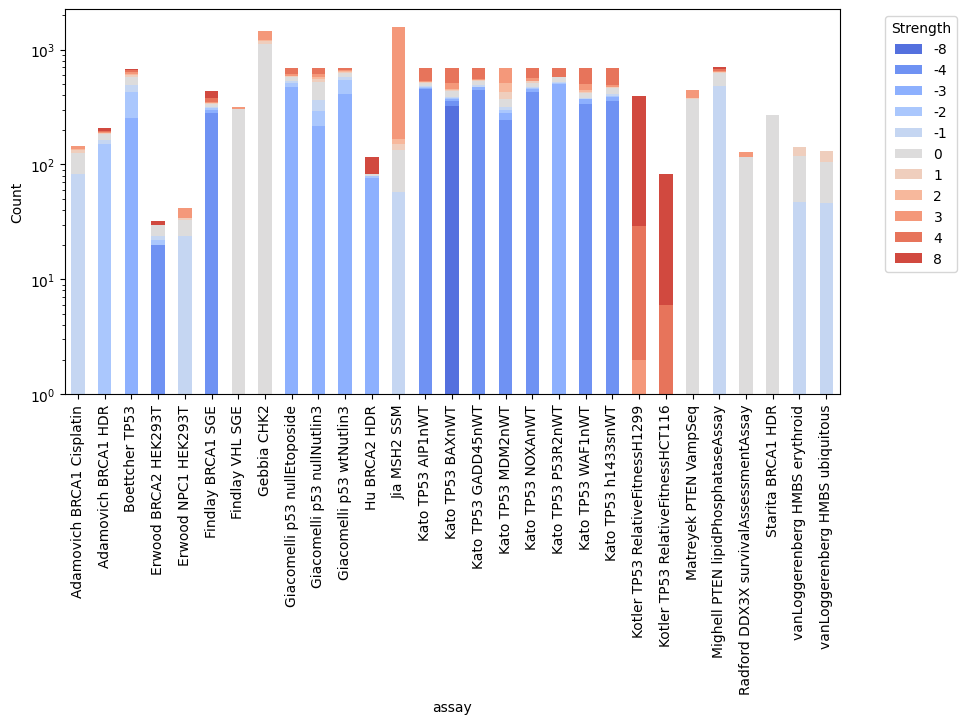

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
# pivot_df = assay_strength_results[assay_strength_results.strength != 0].pivot(index='assay',columns='strength',values='count')
pivot_df = assay_strength_results.pivot(index='assay',columns='strength',values='count')
pivot_df.index = pivot_df.index.str.replace("score_","").str.replace("_strength","").str.replace("_"," ")
pivot_df.plot(kind='bar', stacked=True,color=sns.color_palette("coolwarm",len(pivot_df.columns)),ax=ax)
ax.set_yscale('log')
ax.legend(title='Strength', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Count")
fig.savefig(results_dir / "vus_assay_evidence_strengths.jpg",bbox_inches='tight')


In [15]:
point_cutoffs = dict(pathogenic=10,likely_pathogenic=6,likely_benign=-1,benign=-7)

In [51]:
all_evidence = []
for i,r in df.iterrows():
    assay_name = r[assay_strength_columns].abs().idxmax()
    conflicting_assay_interpretation = False
    other_assays = list(set(assay_strength_columns) - set((assay_name,)))
    if (r[assay_name] > 0 and (r[other_assays] < -1 * r[assay_name]).any()) or \
        (r[assay_name] < 0 and (r[other_assays] > -1 * r[assay_name]).any()):
        assay_points=0
        conflicting_assay_interpretation = True
    assay_points = r[assay_name]
    absent_from_gnomAD = np.isnan(r.gnomAD_exomes_AF) & np.isnan(r.gnomAD_genomes_AF)
    all_evidence.append(dict(Name=r.Name,
                        GeneSymbol=r.GeneSymbol,
                        revel_score=r.REVEL_score_avg,
                        revel_points=r.revel_strength,
                        og_assay_points=assay_points,
                        assay_points=min(4,assay_points) if assay_points > 0 else max(-4,assay_points) if assay_points < 0 else 0,
                        assay_score = r[assay_name.replace("_strength","")],
                        assay_name=assay_name,
                        absent_from_gnomAD_points=1 if absent_from_gnomAD else 0,
                        conflicting_assay_interpretation=conflicting_assay_interpretation,))
all_evidence = pd.DataFrame(all_evidence)
all_evidence = all_evidence.assign(total_points=all_evidence.revel_points + all_evidence.assay_points + all_evidence.absent_from_gnomAD_points)


In [52]:
all_evidence[all_evidence.total_points >= point_cutoffs["pathogenic"]]

,Name,GeneSymbol,revel_score,revel_points,og_assay_points,assay_points,assay_score,assay_name,absent_from_gnomAD_points,conflicting_assay_interpretation,total_points


In [53]:
LP_candidates = all_evidence[(all_evidence.total_points < point_cutoffs["pathogenic"]) & \
                                (all_evidence.total_points >= point_cutoffs["likely_pathogenic"])].reset_index(drop=True)

In [55]:
LP_candidates

,Name,GeneSymbol,revel_score,revel_points,og_assay_points,assay_points,assay_score,assay_name,absent_from_gnomAD_points,conflicting_assay_interpretation,total_points
0,NM_007294.4(BRCA1):c.5123C>T (p.Ala1708Val),BRCA1,0.789,2,8,4,-1.266224,score_Adamovich_BRCA1_HDR_strength,0,False,6
1,NM_000059.4(BRCA2):c.8300C>G (p.Pro2767Arg),BRCA2,0.845,2,8,4,0.763698,score_Hu_BRCA2_HDR_strength,0,False,6
2,NM_000059.4(BRCA2):c.9539T>C (p.Leu3180Pro),BRCA2,0.751,1,8,4,1.368166,score_Hu_BRCA2_HDR_strength,1,False,6
3,NM_000059.4(BRCA2):c.8356G>C (p.Ala2786Pro),BRCA2,0.752,1,8,4,1.226720,score_Hu_BRCA2_HDR_strength,1,False,6
4,NM_000059.4(BRCA2):c.9215T>A (p.Val3072Glu),BRCA2,0.864,2,8,4,0.972312,score_Hu_BRCA2_HDR_strength,1,False,7
...,...,...,...,...,...,...,...,...,...,...,...
875,NM_000251.3(MSH2):c.1039A>C (p.Lys347Gln),MSH2,0.900,2,3,3,-4.444694,score_Jia_MSH2_SSM_strength,1,False,6
876,NM_000251.3(MSH2):c.2359C>T (p.Leu787Phe),MSH2,0.900,2,3,3,-1.613211,score_Jia_MSH2_SSM_strength,1,False,6
877,NM_007194.4(CHEK2):c.1047G>C (p.Lys349Asn),CHEK2,0.848,2,3,3,-0.040000,score_Gebbia_CHK2_strength,1,False,6
878,NM_007194.4(CHEK2):c.363T>G (p.Cys121Trp),CHEK2,0.856,2,3,3,-0.180000,score_Gebbia_CHK2_strength,1,False,6


In [56]:
LP_candidates.to_csv(results_dir / "ClinVar_VUS_to_likely_pathogenic_candidates.csv")

In [57]:
LB_candidates = all_evidence[(all_evidence.total_points < point_cutoffs["likely_benign"]) & \
            (all_evidence.total_points >= point_cutoffs["benign"])]

In [60]:
LB_candidates

,Name,GeneSymbol,revel_score,revel_points,og_assay_points,assay_points,assay_score,assay_name,absent_from_gnomAD_points,conflicting_assay_interpretation,total_points
9,NM_000059.4(BRCA2):c.8732C>A (p.Ala2911Glu),BRCA2,0.171,-2,-3,-3,4.526709,score_Hu_BRCA2_HDR_strength,1,False,-4
11,NM_007294.4(BRCA1):c.161A>G (p.Gln54Arg),BRCA1,0.616,0,-4,-4,-0.122194,score_Findlay_BRCA1_SGE_strength,0,False,-4
19,NM_000059.4(BRCA2):c.2693G>C (p.Arg898Thr),BRCA2,0.163,-2,0,0,NaN,score_Adamovich_BRCA1_Cisplatin_strength,0,False,-2
24,NM_000059.4(BRCA2):c.440A>T (p.Gln147Leu),BRCA2,0.183,-2,0,0,NaN,score_Adamovich_BRCA1_Cisplatin_strength,0,False,-2
30,NM_000059.4(BRCA2):c.7618C>A (p.Leu2540Met),BRCA2,0.594,0,-3,-3,4.998341,score_Hu_BRCA2_HDR_strength,0,False,-3
...,...,...,...,...,...,...,...,...,...,...,...
10446,NM_000546.6(TP53):c.166G>A (p.Glu56Lys),TP53,0.478,0,-8,-4,-0.862840,score_Kato_TP53_BAXnWT_strength,1,False,-3
10473,NM_000059.4(BRCA2):c.3466T>G (p.Ser1156Ala),BRCA2,0.191,-1,-4,-4,1.031166,score_Erwood_BRCA2_HEK293T_strength,1,False,-4
10539,NM_000059.4(BRCA2):c.8345G>A (p.Ser2782Asn),BRCA2,0.596,0,-3,-3,4.993608,score_Hu_BRCA2_HDR_strength,0,False,-3
10572,NM_000546.6(TP53):c.1054G>A (p.Asp352Asn),TP53,0.536,0,-8,-4,-0.075362,score_Kato_TP53_BAXnWT_strength,1,False,-3


In [61]:
LB_candidates.to_csv(results_dir / "ClinVar_VUS_to_likely_benign_candidates.csv")

In [62]:
all_evidence[(all_evidence.total_points < point_cutoffs["benign"])]

,Name,GeneSymbol,revel_score,revel_points,og_assay_points,assay_points,assay_score,assay_name,absent_from_gnomAD_points,conflicting_assay_interpretation,total_points


<Axes: >

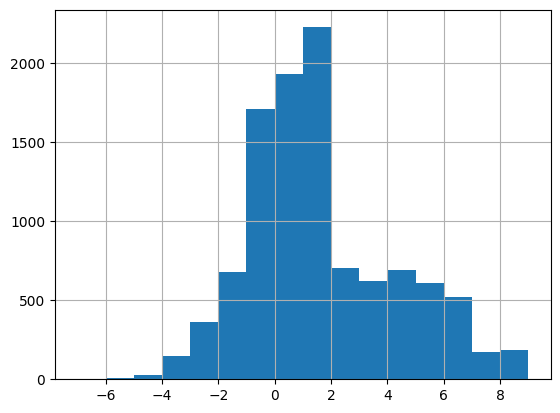

In [63]:
all_evidence.total_points.hist(bins=np.arange(all_evidence.total_points.min() - 1,
                                                all_evidence.total_points.max() + 1,
                                                1))

In [64]:
LP_candidates.loc[:,["assay_points","revel_points", "absent_from_gnomAD_points"]].value_counts().sort_index().to_frame().to_csv(results_dir / "LP_candidate_points_distribution.csv")

In [65]:
all_evidence.loc[:,["assay_points","revel_points", "absent_from_gnomAD_points","total_points"]].value_counts().to_frame().sort_values('total_points').to_csv(results_dir / "all_evidence_points_distribution.csv")

In [66]:
pd.concat((LP_candidates,LB_candidates)).loc[:,['total_points',"assay_points","revel_points", "absent_from_gnomAD_points",]].value_counts().to_frame().sort_values(['total_points',
                                                                                                                                                                    "assay_points",
                                                                                                                                                                    "revel_points",
                                                                                                                                                                    "absent_from_gnomAD_points"]).to_csv(results_dir / "LP_LB_candidate_points_distribution.csv")

In [118]:
LP_candidates.shape[0],LB_candidates.shape[0], LP_candidates.shape[0] + LB_candidates.shape[0]

(880, 1220, 2100)